# Zero shot anomaly detection on MVTec

In [1]:
import os
import math
import argparse
from tqdm import tqdm

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random

from Datasets import DATASET_REGISTRY

In [2]:
def load_dinov3_local(repo_dir, model_name, weights, device):
    """
    Load a local DINOv3 model via torch.hub (repo_dir points to the dinov3 repo).
    model_name: e.g. 'dinov3_vits16' or 'dinov3_vitl16'
    weights: path to local checkpoint
    """
    model = torch.hub.load(repo_dir, model_name, source='local', weights=weights)
    model.to(device)
    model.eval()
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

Dino = load_dinov3_local("dinov3", "dinov3_vits16", "dinov3_vits16_pretrain_lvd1689m-08c60483.pth", device)

cuda:0


In [3]:
def prepare_data_from_registry(dataset_name, category, batch_size, device, resize=512, imagesize=512, **kwargs):
    dataset_name = dataset_name.lower()
    if DATASET_REGISTRY is None:
        raise RuntimeError("DATASET_REGISTRY not available. Provide images differently.")
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    dataset_cls, split_cls, root_path = DATASET_REGISTRY[dataset_name]
    test_dataset = dataset_cls(source=root_path, split=split_cls.TEST, classname=category, resize=resize, imagesize=imagesize)
    loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    return loader

dataloader = prepare_data_from_registry("mvtec", "metal_nut", 4, device)

mvtec_anomaly_detection/metal_nut/test


In [4]:
def get_sample_from_registry(dataset_name, category, resize=512, imagesize=512, **kwargs):
    dataset_name = dataset_name.lower()
    if DATASET_REGISTRY is None:
        raise RuntimeError("DATASET_REGISTRY not available. Provide images differently.")
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    dataset_cls, split_cls, root_path = DATASET_REGISTRY[dataset_name]
    test_dataset = dataset_cls(source=root_path, split=split_cls.TEST, classname=category, resize=resize, imagesize=imagesize)
    idx = random.randint(0, len(test_dataset) - 1)
    sample = test_dataset[idx]   # returns dict
    return sample

test_image = get_sample_from_registry("mvtec", "metal_nut")

mvtec_anomaly_detection/metal_nut/test


mvtec_anomaly_detection/metal_nut/test


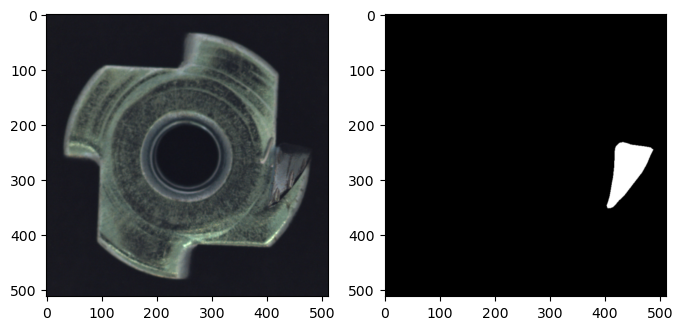

In [5]:
test_image = get_sample_from_registry("mvtec", "metal_nut")

fig, ax = plt.subplots(1,2, figsize=(8,4))

image = test_image['image']
mask = test_image['mask']

ax[0].imshow(image.permute(1,2,0).cpu())
ax[1].imshow(mask.squeeze().cpu(), cmap='gray')
plt.show()

mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test


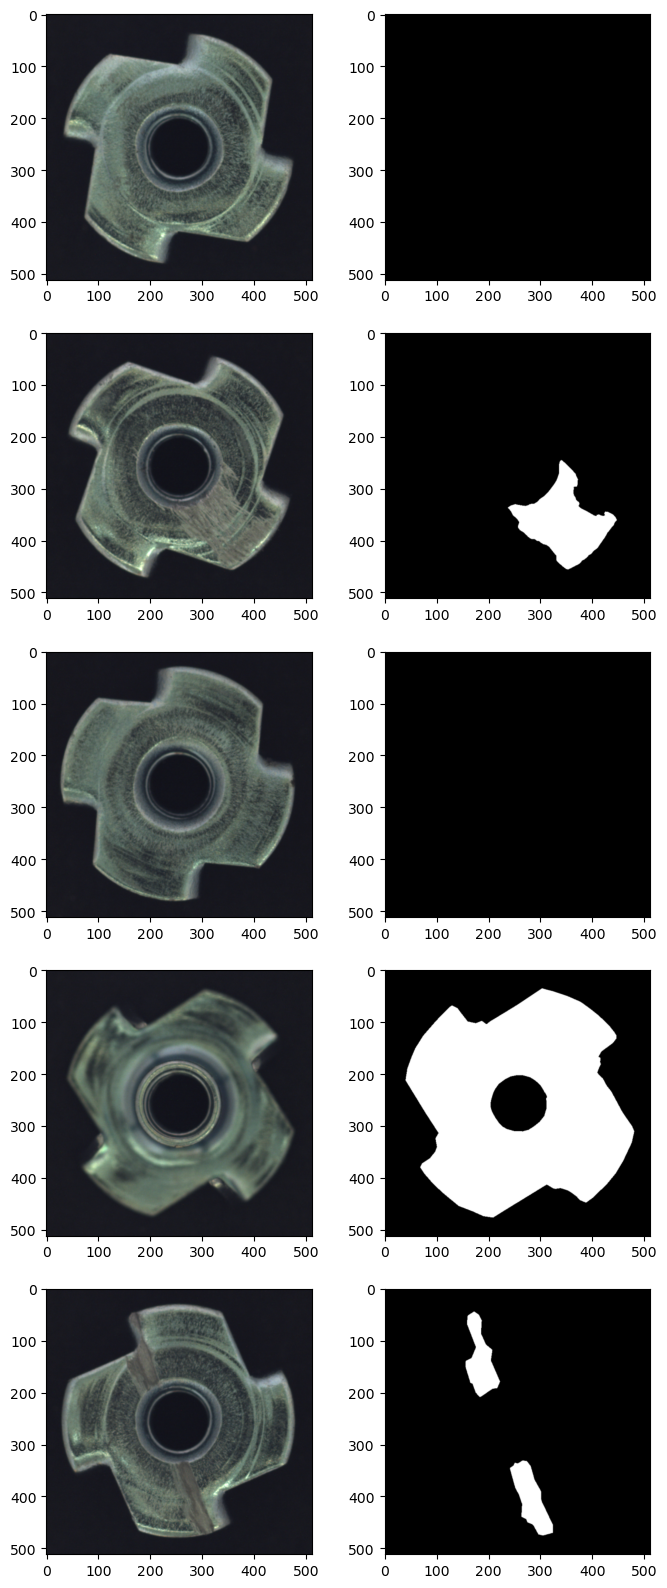

In [6]:
fig, ax = plt.subplots(5,2, figsize=(8,20))

for i in range(5):

    sample = get_sample_from_registry("mvtec", "metal_nut")
    batch = {'image': sample['image'].unsqueeze(0), 'mask': sample['mask'].unsqueeze(0)}
    image = batch['image']
    mask = batch['mask']

    ax[i,0].imshow(image[0].permute(1,2,0).cpu())
    ax[i,1].imshow(mask[0].squeeze().cpu(), cmap='gray')

plt.show()

In [7]:
all_labels = []
all_embeddings = []
torch.cuda.empty_cache()
Dino.eval()
for batch in tqdm(dataloader):
    data = batch['image']
    labels = batch['mask']
    new_labels = labels.numpy().tolist()
    all_labels += new_labels
    data = data.to(device)
    embeddings = Dino(data.to(device))
    all_embeddings.append(np.reshape(embeddings.detach().cpu().numpy(),(len(new_labels),-1)))
all_embeddings = np.vstack(all_embeddings)

100%|██████████| 29/29 [00:04<00:00,  6.34it/s]


In [8]:
all_embeddings[0].shape

(384,)

mvtec_anomaly_detection/metal_nut/test


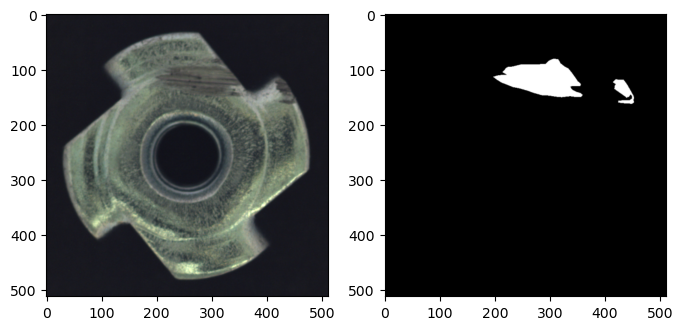

In [9]:
from DataHandler import DataSampler

sample = DataSampler.get_sample_from_registry("mvtec", "metal_nut")

fig, ax = plt.subplots(1,2, figsize=(8,4))

image = sample['image']
mask = sample['mask']

ax[0].imshow(image.permute(1,2,0).cpu())
ax[1].imshow(mask.squeeze().cpu(), cmap='gray')
plt.show()

In [10]:
all_good_samples = DataSampler.get_all_good_samples_from_category("mvtec", "bottle")
all_good_samples[0]

mvtec_anomaly_detection/bottle/train
Found 209 good samples in category 'bottle' of dataset 'mvtec'.


{'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.,

In [11]:
good_images = [sample['image'].unsqueeze(0) for sample in all_good_samples]
good_images = torch.cat(good_images, dim=0)
good_masks = [sample['mask'].unsqueeze(0) for sample in all_good_samples]
good_masks = torch.cat(good_masks, dim=0)

In [12]:
good_masks[0].shape

torch.Size([1, 512, 512])

In [13]:
sample["image"].shape

torch.Size([3, 512, 512])

### Philip method

In [14]:
from torchvision.transforms import v2
from PIL import Image

def make_transform(resize_size: int = 256):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

pre_process = make_transform(resize_size = 256) #Could change size if we want

# image_tensor = pre_process(sample["image"])
# image_tensor_normal = good_images[0]
# image_tensor_ground_truth = good_masks[0]

In [15]:
# Change path to your own directory of git folder
root_path = "/home/knudm/Documents/University/DTU/Semester 4/02456 - Deep Learning/ZeroShot_Anomaly_Detection_using_Vision_Foundation_Models/mvtec_anomaly_detection"
good_image_path   = f"{root_path}/metal_nut/train/good/000.png"
test_image_path   = f"{root_path}/metal_nut/test/scratch/012.png"
ground_truth_path = f"{root_path}/metal_nut/ground_truth/scratch/012_mask.png"

In [16]:
image_broken = Image.open(test_image_path).convert("RGB")
image_norm = Image.open(good_image_path).convert("RGB")
image_tensor_broken = pre_process(image_broken).unsqueeze(0)   # Add batch dim
image_tensor_normal = pre_process(image_norm).unsqueeze(0)

image_gnd_truth = Image.open(ground_truth_path).convert("RGB")

image_tensor_broken = image_tensor_broken.to(device)
image_tensor_normal = image_tensor_normal.to(device)
# image_gnd_truth.to(device)

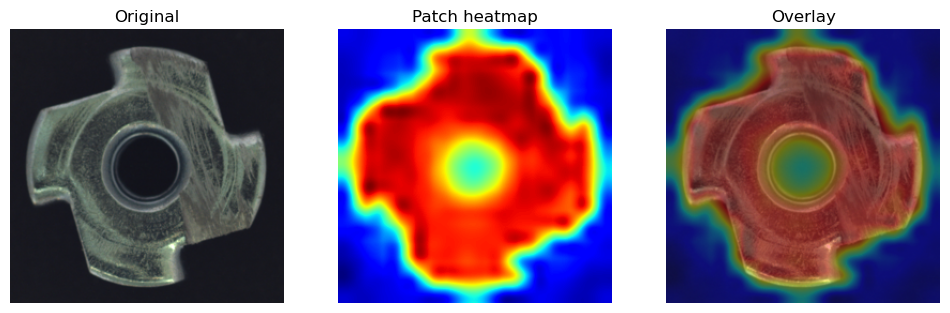

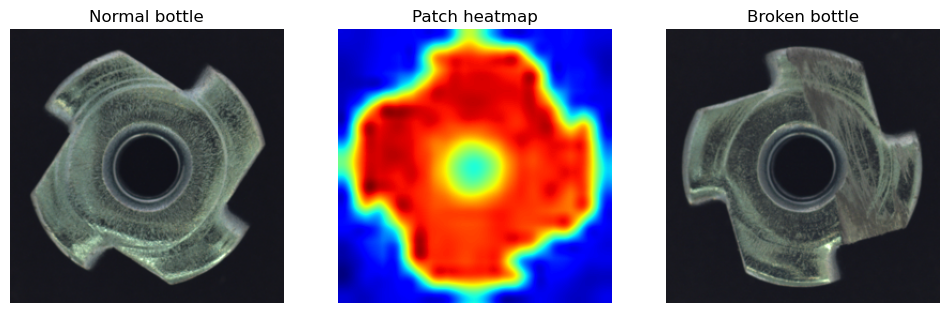

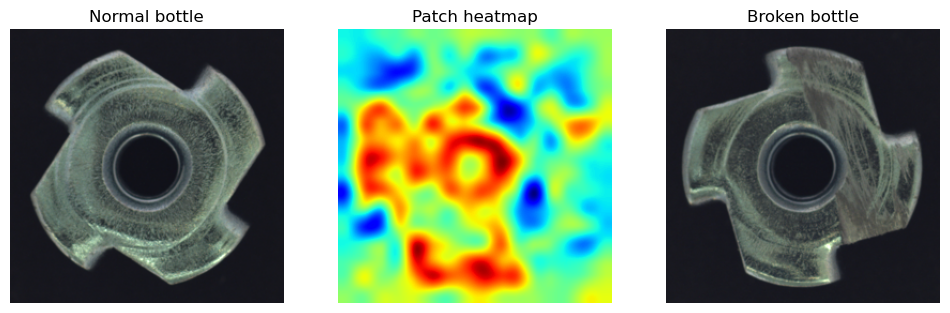

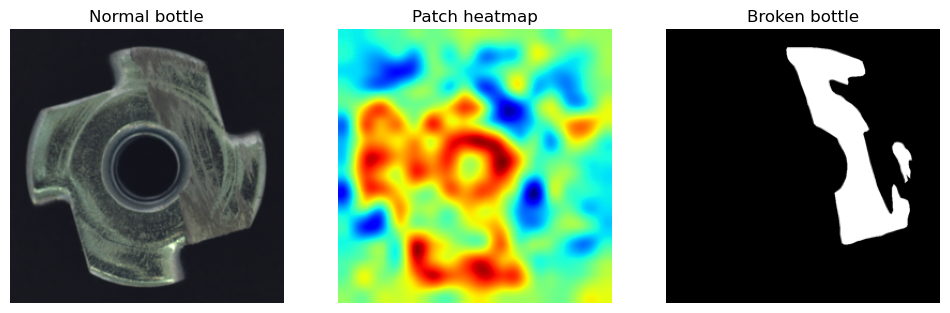

In [17]:
model = Dino
model.to(device)
model.eval()
with torch.no_grad():
    features_dict = model.forward_features(image_tensor_broken)  # Usually outputs a tensor [1, 768] for vitb16
    #Also for the non-broken one
    features_dict_normal = model.forward_features(image_tensor_normal)



#Now we have a dictionary, with clstoken and a tensor. We only want the tensor.
features = features_dict["x_norm_patchtokens"]


# print(f'Features shape {features.shape}')
# print(f'Features other than patchtokens shape {features_dict["x_prenorm"].shape}')
# print(features[0, :10])  # Print first 10 feature values

#Save as a np.array, and then resize it, and show it.
B, N, C = features.shape

# 2. Reshape [16, 16, 384]
H = W = int(N ** 0.5)
tokens_grid = features.reshape(1, H, W, C)

# 3. Turn each 384-d vector into a scalar (L2 norm)
#heatmap = torch.norm(tokens_grid, dim=-1)  # shape [1, 16, 16]
#Try the mean intead.
#heatmap = tokens_grid.mean(dim=-1)
#Try Variance
#heatmap = tokens_grid.var(dim=-1)

#Try similaitry to CLS tokens.
cls = features_dict["x_norm_clstoken"]  # [1,384]
cls = cls.expand_as(features[:, :N])

cls_norm = features_dict_normal["x_norm_clstoken"]
cls_norm = cls_norm.expand_as(features[:, :N])

#sim = torch.einsum("nc,nc->n", features.squeeze(0), cls.squeeze(0)) #Dot product for each patch vs. the global cls token.
#Try cosine similarity instead:
sim = F.cosine_similarity(
    features.squeeze(0), 
    cls.squeeze(0), 
    dim=-1
)

#Now try cosine similarity between cls tokens from a non-broken bottle, and patch tokens from a broken one.
sim_norm = F.cosine_similarity(
    features.squeeze(0),
    cls_norm.squeeze(0),
    dim =-1
)


heatmap = sim.reshape(H, W)

heatmap_cls_norm = sim_norm.reshape(H,W)

# 4. Normalize to [0, 1]
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

heatmap_cls_norm_norm = (heatmap_cls_norm - heatmap_cls_norm.min()) / (heatmap_cls_norm.max() - heatmap_cls_norm.min())

# 5. Upsample from 16×16 to 256×256 using PyTorch
heatmap_up = F.interpolate(
    heatmap_norm.unsqueeze(0).unsqueeze(0),  
    size=(256, 256),
    mode="bicubic",
    align_corners=False
)[0, 0].cpu().numpy()

#Vs. cls from normal bottle.
heatmap_up_cls_norm = F.interpolate(
    heatmap_cls_norm_norm.unsqueeze(0).unsqueeze(0),  
    size=(256, 256),
    mode="bicubic",
    align_corners=False
)[0, 0].cpu().numpy()


# 6. Convert original image to numpy (resize to 256)
image_np = np.array(image_broken.resize((256, 256)))

#Also, print the normal pic.
image_norm_np = np.array(image_norm.resize((256, 256)))

#Ground truth pic:
image_gnd_truth_np = np.array(image_gnd_truth.resize((256, 256)))

# 7. Apply matplotlib colormap (jet)
colormap = plt.cm.jet
heatmap_color = colormap(heatmap_up)[:, :, :3]  # remove alpha channel
heatmap_color = (heatmap_color * 255).astype(np.uint8)

#Copy for the other picture.
colormap2 = plt.cm.jet
heatmap_color2 = colormap(heatmap_up_cls_norm)[:, :, :3]
heatmap_color2 = (heatmap_color2*255).astype(np.uint8)


# 8. Blend heatmap + image
overlay = (0.6 * image_np + 0.4 * heatmap_color).astype(np.uint8)

# 9. Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(image_np); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.show()

# 10. Visulatize second pic with normal cls_tokens
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Normal bottle"); plt.imshow(image_norm_np); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up_cls_norm, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Broken bottle"); plt.imshow(image_np); plt.axis("off")
plt.show()


# 11. Visulatize second pic with normal cls_tokens and difference with broken broken picture.
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Normal bottle"); plt.imshow(image_norm_np); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up_cls_norm-heatmap_up, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Broken bottle"); plt.imshow(image_np); plt.axis("off")
plt.show()

#12. Visualize the ground truth.
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Normal bottle"); plt.imshow(image_np); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up_cls_norm-heatmap_up, cmap='jet'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Broken bottle"); plt.imshow(image_gnd_truth_np); plt.axis("off")
plt.show()